In [1]:
%matplotlib inline
import sys
import os
import re
import numpy as np
import math
import pandas as pd
import copy as cp
import colorsys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import cm
from matplotlib import colors
from matplotlib import rc, rcParams

from scipy import stats
import scipy.special
from scipy.integrate import simps

import bootstrapped.bootstrap as bs

This notebook plots creates panels C, D and E for Figure 8.  
  
Panels A and B are plotted in the end of the notebook by reading in the values generated by the script simulate.py

In [2]:
#### all the helping functions 

def RMSE_function(values):
    tmp = np.sqrt(np.mean(values*values,axis=1))
    return tmp


def tau_function(a):
    s = a.shape
    tmp = np.array([])
    if len(s) == 2:
        tmp = scipy.stats.kendalltau(a[:,0],a[:,1])
    else:
        for i in range(s[0]):
            x = scipy.stats.kendalltau(a[i,:,0],a[i,:,1])[0]
            if x == np.nan:
                tmp = np.append(tmp,0.0)
            else:
                tmp = np.append(tmp,x)
    return tmp

def eval_stats(exp,pred,N):
    error = np.abs(exp-pred)
    rmse_bootstrap_dist = bs.bootstrap(np.reshape(error,(N,-1)), stat_func=RMSE_function,num_iterations=1000, alpha =0.05,is_pivotal=True,return_distribution=True)
    rmse = np.sqrt(np.mean(error**2))
    tau = scipy.stats.kendalltau(exp,pred)[0]
    tau_bootstrap_dist = bs.bootstrap(np.reshape(np.array(list(zip(exp,pred))),(N,-1)), stat_func=tau_function,num_iterations=1000, alpha =0.05,is_pivotal=True,return_distribution=True)
    tmp1 = [rmse,np.percentile(rmse_bootstrap_dist,2.5),np.percentile(rmse_bootstrap_dist,97.5),tau,np.percentile(tau_bootstrap_dist,2.5),np.percentile(tau_bootstrap_dist,97.5)]
    return tmp1

def eval_rmse(exp,pred,N,bootnum=1000):
    error = np.abs(exp-pred)
    rmse_bootstrap_dist = bs.bootstrap(np.reshape(error,(N,-1)), stat_func=RMSE_function,num_iterations=bootnum, alpha =0.05,is_pivotal=True,return_distribution=True)
    rmse = np.sqrt(np.mean(error**2))
    tmp1 = [rmse,np.percentile(rmse_bootstrap_dist,2.5),np.percentile(rmse_bootstrap_dist,97.5)]
    return tmp1

def eval_rmse_vytas(exp,pred,n,bootnum=1000):
    rmse = np.sqrt( np.mean(np.power(exp-pred,2.0)))
    error = np.power(exp-pred,2.0)
    err = []
    for boot in range(0,bootnum):
        rand = np.random.choice(n, n, replace=True)
        err.append( np.sqrt( np.mean( error[rand] )) )
        
    err = np.sort(err)
    low = err[int(bootnum*0.025)]
    high = err[int(bootnum*0.975)]
    tmp1 = [rmse,low,high]
    return tmp1

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [3]:
# this function performs bootstrapping of datapoints {exp,predA,predB}
# since the points in these datasets are dependent, bootstrapping procedures takes this into account
# RMSE is calculated for every resampled distribution 
# distribution of the RMSE differences (RMSE_A-RMSE_B) is constructed
# two-tailed significance test is performed to identify whether the RMSE difference is statistically significant

def get_significance( exp, predA, predB, n, alpha=0.05, bootnum=1000, bReturnDiff=False ):
    rmseA = np.sqrt( np.mean(np.power(exp-predA,2.0)))
    rmseB = np.sqrt( np.mean(np.power(exp-predB,2.0)))
    errorA = np.power(exp-predA,2.0)
    errorB = np.power(exp-predB,2.0)    
    diff = []
    for boot in range(0,bootnum):
        rand = np.random.choice(n, n, replace=True)
        foo_rmseA = np.sqrt( np.mean( errorA[rand] ))
        foo_rmseB = np.sqrt( np.mean( errorB[rand] ))
        foo_diff = foo_rmseA-foo_rmseB
        diff.append(foo_diff)
        
    diff = np.sort(diff)
    pos = np.shape( np.where( diff > 0.0 ) )[1]/float(bootnum)
    neg = np.shape( np.where( diff < 0.0 ) )[1]/float(bootnum)
    bSignif = False
    # more than 0.975 values are negative
    if pos < alpha/2.0:
        bSignif = True
    # more than 0.975 values are positive
    elif neg < alpha/2.0:
        bSignif = True 
    if bReturnDiff:
        return(bSignif,diff)
    else:
        return(bSignif)

--------------
Panels C, D, E: Investigate significance in RMSE difference for two sets of points
---------------

Simulate sampling as done in the panels A, B of the Figure 8 and focus on the N=10 set size only.

For illustration in the panels C,D,E find such a case where the RMSE to experiment for the two sets of points differ significantly, yet their error bars overlap

In [4]:
np.random.seed( 25 )

#generate toy data in interval [-12:-5]
all_results = {}
NN = [10] #,25,35,50,75,100,200]
for N in NN:
#  simulate experimental data as uniform distribution
    data = [ np.random.uniform(low=-12,high=-5,size=N) for x in range(1000)]
    
    tmpresults05 = []
    tmpresults1 = []
    tmpresults15 = []
    bSignif05_1 = False
    bSignif05_15 = False
    bSignif1_15 = False
    signif05_1 = []
    signif05_15 = []
    signif1_15 = []
    
    results = []
    
    for i in data:
        #simulated predicted data with gaussian error and calculate statistics for datasets   
        i_pred05 = i + np.random.normal(0,0.5,N)
        i_pred1 = i + np.random.normal(0,1.0,N)
        i_pred15 = i + np.random.normal(0,1.5,N)
        
        results05 = eval_rmse(i,i_pred05,N)
        results1 = eval_rmse(i,i_pred1,N)
        results15 = eval_rmse(i,i_pred15,N)
        
        tmpresults05.append(results05)
        tmpresults1.append(results1)
        tmpresults15.append(results15)
        
        # Let's find such a case where confidence intervals overlap, but the difference is significant
        if bSignif05_1==False:
            # check significance
            bSignif05_1 = get_significance( i, i_pred05, i_pred1, N )
            # check if the CI overlap
            if (bSignif05_1==True) and (results1[1]<results05[0]):
                signif05_1.append( i )
                signif05_1.append( i_pred05 )
                signif05_1.append( i_pred1 )
            else:
                bSignif05_1 = False
#        if bSignif05_15==False:            
#            bSignif05_15 = get_significance( i, i_pred05, i_pred15, N )
#            signif05_15.append( i )
#            signif05_15.append( i_pred05 )
#            signif05_15.append( i_pred15 )            
        if bSignif1_15==False:
            # check significance
            bSignif1_15 = get_significance( i, i_pred1, i_pred15, N )
            # check if the CI overlap
            if (bSignif1_15==True) and (results15[1]<results1[0]):
                signif1_15.append( i )
                signif1_15.append( i_pred1 )
                signif1_15.append( i_pred15 )
            else:
                bSignif1_15 = False
        
    tmpresults05 = np.array(tmpresults05)
    tmpresults1 = np.array(tmpresults1)
    tmpresults15 = np.array(tmpresults15)
    
    results.append(np.mean(tmpresults05,axis=0))
    results.append(np.mean(tmpresults1,axis=0))
    results.append(np.mean(tmpresults15,axis=0))    
    
    all_results[N] = results

#all_results = np.array(all_results)
#all_results = np.reshape(all_results,(-1,24))
#import pandas as pd
#df = pd.DataFrame(all_results,columns=['mean_rmse_0.5','low_rmse_0.5','high_rmse_0.5','mean_tau_0.5','low_tau_0.5','high_tau_0.5','mean_rmse_1.0','low_rmse_1.0','high_rmse_1.0','mean_tau_1.0','low_tau_1.0','high_tau_1.0','mean_rmse_1.5','low_rmse_1.5','high_rmse_1.5','mean_tau_1.5','low_tau_1.5','high_tau_1.5','mean_rmse_2.0','low_rmse_2.0','high_rmse_2.0','mean_tau_2.0','low_tau_2.0','high_tau_2.0'])
#df['N']= NN

In [5]:
def plot_rmse(rmse1, rmse2, clr1, clr2):
    # rmse1
    plt.scatter(1.0,rmse1[0],color=clr1,s=450,marker='o',zorder=2,alpha=0.8)
    # asymmetric errorbar
    errlow = rmse1[0] - rmse1[1]
    errhigh = rmse1[2] - rmse1[0]
    plt.errorbar(1.0,rmse1[0],yerr=[[errlow],[errhigh]],fmt='none',ecolor=clr1,zorder=1,mew=4, capsize=6, elinewidth=4)    

    # rmse2
    plt.scatter(2.0,rmse2[0],color=clr2,s=450,marker='o',zorder=2,alpha=0.8)
    # asymmetric errorbar
    errlow = rmse2[0] - rmse2[1]
    errhigh = rmse2[2] - rmse2[0]
    plt.errorbar(2.0,rmse2[0],yerr=[[errlow],[errhigh]],fmt='none',ecolor=clr2,zorder=1,mew=4, capsize=6, elinewidth=4)    

    # x-axis
    ax.xaxis.set_ticks_position('bottom')
    #ax.tick_params(axis='x',labelbottom='off')
    x = [1,2]    
    xlabels = [r'$\sigma=1.0$',r'$\sigma=1.5$']
    plt.xticks(x,xlabels,fontsize=22)
    
    # y-axis
    ax.yaxis.set_ticks_position('left')
    y = [0,0.5,1.0,1.5,2.0,2.5]
    plt.yticks(y,y,fontsize=22)
    plt.ylabel(r'RMSE, kcal/mol',fontsize=22,rotation=90)
    
def plot_scatter(x, y1, y2, clr1, clr2):
    plt.scatter(x,y1,color=clr1,s=100,marker='o',zorder=2,alpha=1)
    plt.scatter(x,y2,color=clr2,s=100,marker='o',zorder=2,alpha=1)
    
    # plot the lines
    for i,j1,j2 in zip(x,y1,y2):
        clr = clr2
        if j1>j2:
            clr = clr1
        plt.plot([i,i],[j1,j2],color=clr,lw=2,zorder=1)

    # x-axis
    ax.xaxis.set_ticks_position('bottom')
    x = [1,2]    
    plt.xticks(fontsize=16)
    plt.xlabel(r'$\Delta G_{exp}$, kcal/mol',fontsize=22,rotation=0)
    ax.yaxis.labelpad = -5
    
    # y-axis
    ax.yaxis.set_ticks_position('left')
    plt.yticks(fontsize=16)
    plt.ylabel(r'$\Delta G_{calc}$, kcal/mol',fontsize=22,rotation=90)
        
def plot_diff_distr(diff, clr1, clr2, alpha=0.05):
    
    def get_kde_1D(positions,val1):
        values = val1
        kernel = stats.gaussian_kde(values)
        kernel.covariance_factor = lambda : .25
        kernel._compute_covariance()
        f = kernel.evaluate(positions)
        return(f)
    
    xmin = np.min(diff)-0.5
    xmax = np.max(diff)+0.5
    x = np.mgrid[xmin:xmax:100j]
    positions = x.ravel()
    kde = get_kde_1D(positions,diff)
    # less than 0.0
    ind = np.where( positions < 0.0 )
    plt.plot(positions[ind],kde[ind],color=clr1,linewidth=4,linestyle='-', alpha=0.8,zorder=1)     
    # more than 0.0
    ind = np.where( positions > 0.0 )
    plt.plot(positions[ind],kde[ind],color=clr2,linewidth=4,linestyle='-', alpha=0.8,zorder=1)   
    
    # color under the curve and alpha region markings
    n = np.shape(diff)[0] # total number of calculated differences
    val = diff[int(n*alpha/2.0)] # diff value at the 0.025 quantile
    p = np.where(np.abs(positions-val)==np.min(np.abs(positions-val)))[0][0] # index for quantile in positions array
    ax.fill_between(positions[0:p+1], positions[0:p+1]*0.0, kde[0:p+1], facecolor='gray', interpolate=True,alpha=0.25)
    plt.axvline(x=positions[p],color='gray',alpha=0.5)    
    plt.text(positions[p]-0.75, 0.75, r'$\alpha/2$={0}'.format(alpha/2.0),fontsize=20,color='gray')
    
    val = diff[int(n*(1.0-alpha/2.0))] # diff value at the 0.975 quantile
    p = np.where(np.abs(positions-val)==np.min(np.abs(positions-val)))[0][0] # index for quantile in positions array
    ax.fill_between(positions[p:], positions[p:]*0.0, kde[p:], facecolor='gray', interpolate=True,alpha=0.25)
    plt.axvline(x=positions[p],color='gray',alpha=0.5)
    plt.text(positions[p]+0.01, 0.75, r'$1-\alpha/2$={0}'.format(1.0-alpha/2.0),fontsize=20,color='gray')
    
    inds = np.where( positions > -0.01 ) # positive values
    ax.fill_between(positions[inds], positions[inds]*0.0, kde[inds], facecolor=clr2, interpolate=True,alpha=0.25)    
    # vertical line
    p = np.where(np.abs(positions)==np.min(np.abs(positions)))[0][0]
    plt.axvline(x=positions[p],color=clr2,alpha=0.5)
    pval = np.round(np.shape(np.where(diff>0.0))[1]/np.shape(np.where(diff))[1],3)
    plt.text(positions[p]+0.01, 0.5, '$p=${0}'.format(pval),fontsize=20,color=clr2)
    
    # x-axis
    ax.xaxis.set_ticks_position('bottom')
    #ax.tick_params(axis='x',labelbottom='off')
    x = [1,2]    
    xlabels = [r'$\sigma=1.0$',r'$\sigma=1.5$']
    plt.xticks(fontsize=16)
    xlabel = r'$RMSE(\sigma=1.0,exp)-RMSE(\sigma=1.5,exp)$, kcal/mol'
    plt.xlabel(xlabel,fontsize=15,rotation=0)
    ax.yaxis.labelpad = 5
    
    # y-axis
    ax.yaxis.set_ticks_position('left')
    plt.yticks(fontsize=16)
    plt.ylabel(r'$\rho$',fontsize=22,rotation=90)
    ax.yaxis.labelpad = -5
    
    return(kde)     

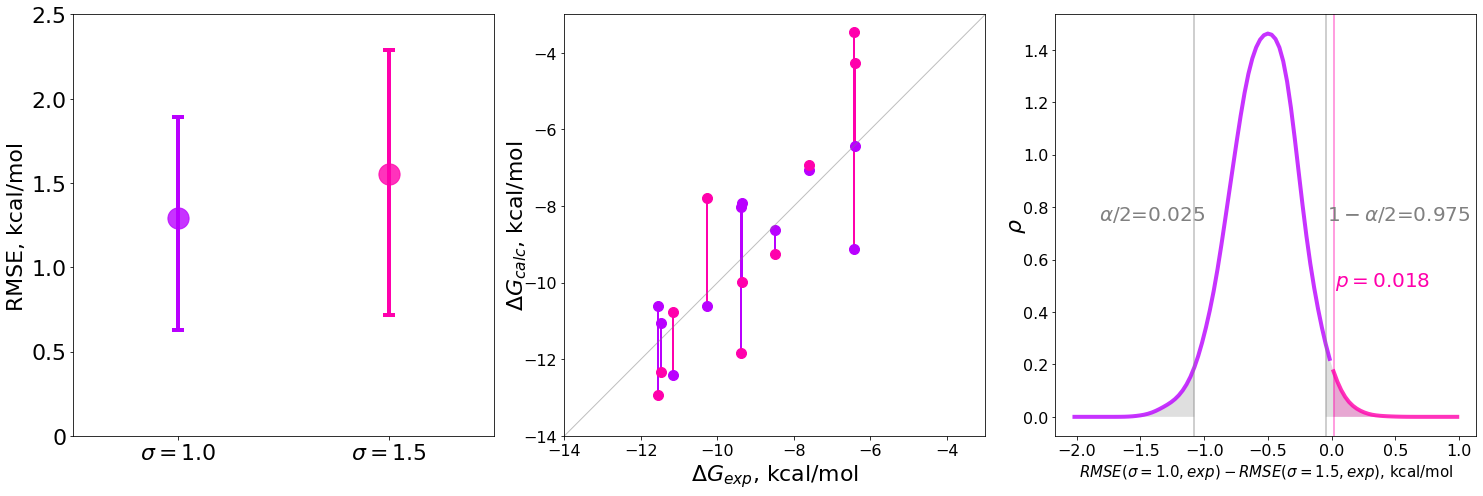

In [6]:
bSign,diff = get_significance(signif1_15[0], signif1_15[1], signif1_15[2], 10, bootnum=10000, bReturnDiff=True )
       
# plot the extra panels
plt.figure(1,figsize=(21,7))
cmap = cm.get_cmap('hsv')

#####################################
# rmse 
#####################################
ax = plt.subplot2grid((1,3), (0,0))
plt.xlim(0.5,2.5)
plt.ylim(0.25,2.0)
plot_rmse(results1, results15, clr1=cmap(0.8), clr2=cmap(0.9))
#do_legend( bPot=True )


#####################################
# scatter 
#####################################
def plot_scatter(x, y1, y2, clr1, clr2):
    plt.scatter(x,y1,color=clr1,s=100,marker='o',zorder=2,alpha=1)
    plt.scatter(x,y2,color=clr2,s=100,marker='o',zorder=2,alpha=1)
    
    # plot the lines
    for i,j1,j2 in zip(x,y1,y2):
        clr = clr2
        if j1>j2:
            clr = clr1
        plt.plot([i,i],[j1,j2],color=clr,lw=2,zorder=1)

    # diagonal
    plt.plot([-100,100],[-100,100],color='gray',lw=1,alpha=0.5)
    
    # x-axis
    ax.xaxis.set_ticks_position('bottom')
    x = [1,2]    
    plt.xticks(fontsize=16)
    plt.xlabel(r'$\Delta G_{exp}$, kcal/mol',fontsize=22,rotation=0)
    ax.yaxis.labelpad = -5
    
    # y-axis
    ax.yaxis.set_ticks_position('left')
    plt.yticks(fontsize=16)
    plt.ylabel(r'$\Delta G_{calc}$, kcal/mol',fontsize=22,rotation=90)

ax = plt.subplot2grid((1,3), (0,1))
plt.xlim(-14,-3)
plt.ylim(-14,-3)
plot_scatter(signif1_15[0], signif1_15[1], signif1_15[2], clr1=cmap(0.8), clr2=cmap(0.9))

#####################################
# difference distribution 
#####################################
ax = plt.subplot2grid((1,3), (0,2))
kde = plot_diff_distr(diff, clr1=cmap(0.8), clr2=cmap(0.9))

plt.tight_layout()
plt.savefig('fig8_panels3-5.png',dpi=300,transparent=False,bbox_inches='tight')
plt.show()

--------------------
Read and plot the values that are calculated with the script simulate.py for panels A and B Fig 8
--------------------

In [7]:
# you need to download the input file 'results_N_CI_error_range7.csv' from the SI to run the following cells

df = pd.read_csv( 'results_N_CI_error_range7.csv' )

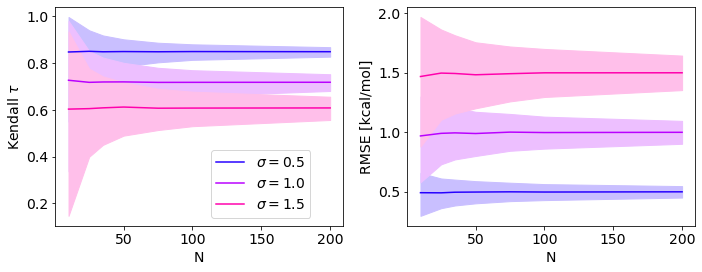

In [8]:
rc('font',**{'size': 14, 'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

cmap = cm.get_cmap('hsv')
rgba = cmap(0.5)
all_results = df
NN = all_results["N"]
lightcolors = [ scale_lightness(x,1.75) for x in [colors.ColorConverter.to_rgb(cmap(0.7)),colors.ColorConverter.to_rgb(cmap(0.8)),colors.ColorConverter.to_rgb(cmap(0.9))]]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

l1 = ax1.plot(NN,all_results["mean_tau_0.5"],color=cmap(0.7),label=r'0.5')[0]
ax1.fill_between(NN,all_results["low_tau_0.5"],all_results["high_tau_0.5"],color=lightcolors[0])
l2 = ax1.plot(NN,all_results["mean_tau_1.0"],color=cmap(0.8))[0]
ax1.fill_between(NN,all_results["low_tau_1.0"],all_results["high_tau_1.0"],color=lightcolors[1])
l3 = ax1.plot(NN,all_results["mean_tau_1.5"],color=cmap(0.9))[0]
ax1.fill_between(NN,all_results["low_tau_1.5"],all_results["high_tau_1.5"],color=lightcolors[2])
ax1.set_xlabel('N')
ax1.set_ylabel(r'Kendall $\tau$')
ax2.plot(NN,all_results["mean_rmse_0.5"],color=cmap(0.7))

ax2.fill_between(NN,all_results["low_rmse_0.5"],all_results["high_rmse_0.5"],color=lightcolors[0])
ax2.plot(NN,all_results["mean_rmse_1.0"],color=cmap(0.8))
ax2.fill_between(NN,all_results["low_rmse_1.0"],all_results["high_rmse_1.0"],color=lightcolors[1])
ax2.plot(NN,all_results["mean_rmse_1.5"],color=cmap(0.9))
ax2.fill_between(NN,all_results["low_rmse_1.5"],all_results["high_rmse_1.5"],color=lightcolors[2])
ax2.set_xlabel('N')
ax2.set_ylabel('RMSE [kcal/mol]')
#plt.text(0.1,1.0,r"$\sigma = 1.0$",rotation=45,verticalalignment='center')
line_labels = [r'$\sigma=0.5$',r'$\sigma=1.0$',r'$\sigma=1.5$']
fig.legend([l1, l2, l3],     # The line objects
           labels=line_labels,   # The labels for each line
           loc=(0.3,0.2),   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           #title="Legend Title"  # Title for the legend
           )
#plt.subplots_adjust(hspace=0.25)
#plt.savefig('N-CI.pdf',bbox_inches='tight')

# plot the two RMSE values that are analyzed in depth

# rmse1
#clr = color=cmap(0.8)
#plt.scatter(10.0,results1[0],color=clr,s=100,marker='o',zorder=2,alpha=0.8)
# asymmetric errorbar
#errlow = results1[0] - results1[1]
#errhigh = results1[2] - results1[0]
#plt.errorbar(10.0,results1[0],yerr=[[errlow],[errhigh]],fmt='none',ecolor=clr,zorder=1,mew=3, capsize=5, elinewidth=3)    

# rmse2
#clr = color=cmap(0.9)
#plt.scatter(10.0,results15[0],color=clr,s=100,marker='o',zorder=2,alpha=0.8)
# asymmetric errorbar
#errlow = results15[0] - results15[1]
#errhigh = results15[2] - results15[0]
#plt.errorbar(10.0,results15[0],yerr=[[errlow],[errhigh]],fmt='none',ecolor=clr,zorder=1,mew=2, capsize=4, elinewidth=2)    

plt.tight_layout()
plt.savefig('fig8_panels1-2.png',dpi=300,transparent=False,bbox_inches='tight')
plt.show()